In [24]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import permanova
from scipy.spatial import distance
from scipy.linalg import khatri_rao
from skbio import DistanceMatrix
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

### functions

In [25]:
def plot_loadings(loadings, mf, 
                  mod_name, comp1, comp2, 
                  cat_of_interest, group_colors):
    
    t_load, s_load, f_load = loadings

    fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
    axn[0].plot(t_load[mod_name][['component_1', 
                                  'component_2', 
                                  'component_3']])
    axn[0].set_title('Temporal Loadings', fontsize=14)
    axn[0].legend(['PC1', 'PC2', 'PC3'])
    axn[1].scatter(s_load[mod_name][comp1],
                   s_load[mod_name][comp2],
                   c=mf[cat_of_interest].map(group_colors))
    axn[1].set_title('Individual Loadings', fontsize=14)
    axn[2].scatter(f_load[mod_name][comp1],
                   f_load[mod_name][comp2], c='black')
    axn[2].set_title('Feature Loadings', fontsize=14)
    plt.suptitle('Joint-CTF results ({})'.format(mod_name), 
                 fontsize=16, y=1.02)
    plt.setp(axn, xlabel=comp1.replace('_', ' '), 
                  ylabel=comp2.replace('_', ' '))
    plt.show()

def plot_feature_cov(tables, mod_cov, components,
                     sharey=True, axis_off=True):
    
    #get feature IDs for each modality
    feature_order = []
    for table in tables:
        feature_ids = table.ids(axis='observation').tolist()
        feature_order = feature_order + feature_ids

    n_comp = len(components)
    fig, axn = plt.subplots(1, n_comp, figsize=(5*n_comp, 4), 
                            sharey=sharey)

    for i, component in enumerate(components):
        cov_table = mod_cov[component]
        cov_table = cov_table.loc[feature_order, feature_order]
        #plot heatmap of feature covariance matrix
        sns.heatmap(cov_table, robust=True, cmap='vlag', 
                    center=0, ax=axn[i])
        axn[i].set_title('{}'.format(component))
    
    if axis_off:
        for ax in axn:
            ax.set_yticks([])
            ax.set_xticks([])

    plt.suptitle('Feature covariance', fontsize=16, y=1.02)
    plt.show()

def sub_feat_trajectory(table, feature_loadings, 
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    floadings = feature_loadings[modality][component]
    table_df = table.to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass

    #drop any NaNs
    beta_l.dropna(inplace=True)

    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[modality][[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

### load and preprocess data

In [26]:
# load filtered tables
body_site = 'Baby-Feces'
baby_gut_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_gut_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Forearm'
baby_skin_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_skin_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Mouth'
baby_mouth_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_mouth_table = load_table('../data/%s/table-filtered.biom' % body_site)

In [27]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
#gut
ids_to_keep = baby_gut_mf[subject_id_column].value_counts()[baby_gut_mf[subject_id_column].value_counts() > 1].index
baby_gut_mf = baby_gut_mf[baby_gut_mf[subject_id_column].isin(ids_to_keep)]
baby_gut_mf = baby_gut_mf[baby_gut_mf.birth_mode_ms != 'CSseed']
#skin
ids_to_keep = baby_skin_mf[subject_id_column].value_counts()[baby_skin_mf[subject_id_column].value_counts() > 1].index
baby_skin_mf = baby_skin_mf[baby_skin_mf[subject_id_column].isin(ids_to_keep)]
baby_skin_mf = baby_skin_mf[baby_skin_mf.birth_mode_ms != 'CSseed']
#mouth
ids_to_keep = baby_mouth_mf[subject_id_column].value_counts()[baby_mouth_mf[subject_id_column].value_counts() > 1].index
baby_mouth_mf = baby_mouth_mf[baby_mouth_mf[subject_id_column].isin(ids_to_keep)]
baby_mouth_mf = baby_mouth_mf[baby_mouth_mf.birth_mode_ms != 'CSseed']

In [28]:
#count how many unique IDs are in each birth mode
print(baby_skin_mf.shape)
print(baby_skin_mf.subjectid_unique.nunique())
print(baby_skin_mf.date_sampling_category_days_continuous.nunique())
print(baby_skin_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(612, 48)
74
18
birth_mode_ms
CS     17
Vag    57
Name: subjectid_unique, dtype: int64


In [29]:
vag_babies = baby_skin_mf[baby_skin_mf.birth_mode_ms == 'Vag']
cs_babies = baby_skin_mf[baby_skin_mf.birth_mode_ms == 'CS']
print("# samples")
print(vag_babies.shape)
print(cs_babies.shape)

print("Mean tps")
print(baby_skin_mf[subject_id_column].value_counts().mean())
print(vag_babies[subject_id_column].value_counts().mean())
print(cs_babies[subject_id_column].value_counts().mean())
print("Max tps")
print(baby_skin_mf[subject_id_column].value_counts().max())
print(vag_babies[subject_id_column].value_counts().max())
print(cs_babies[subject_id_column].value_counts().max())
print("Min tps")
print(baby_skin_mf[subject_id_column].value_counts().min())
print(vag_babies[subject_id_column].value_counts().min())
print(cs_babies[subject_id_column].value_counts().min())

# samples
(432, 48)
(180, 48)
Mean tps
8.27027027027027
7.578947368421052
10.588235294117647
Max tps
17
17
17
Min tps
2
2
5


### Joint-CTF with true data

In [30]:
table1 = clr_transformation(baby_gut_table.copy(), pseudocount=0.5)
table2 = clr_transformation(baby_skin_table.copy(), pseudocount=0.5)
table3 = clr_transformation(baby_mouth_table.copy(), pseudocount=0.5)

In [31]:
#(optional) subset timepoints
baby_gut_mf_90sub = baby_gut_mf[baby_gut_mf.date_sampling_category_days_continuous <= 90]
baby_skin_mf_90sub = baby_skin_mf[baby_skin_mf.date_sampling_category_days_continuous <= 90]

#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = baby_gut_mf_90sub[subject_id_column].value_counts()[baby_gut_mf_90sub[subject_id_column].value_counts() > 1].index
baby_gut_mf_90sub = baby_gut_mf_90sub[baby_gut_mf_90sub[subject_id_column].isin(ids_to_keep)]

ids_to_keep = baby_skin_mf_90sub[subject_id_column].value_counts()[baby_skin_mf_90sub[subject_id_column].value_counts() > 1].index
baby_skin_mf_90sub = baby_skin_mf_90sub[baby_skin_mf_90sub[subject_id_column].isin(ids_to_keep)]

In [32]:
#mf1, mf2 = baby_gut_mf_90sub.copy(), baby_skin_mf_90sub.copy()
mf1, mf2 = baby_gut_mf.copy(), baby_skin_mf.copy()

ctf_results = joint_ctf(tables=[table1, table2],
                        sample_metadatas=[mf1, mf2],
                        modality_ids=['16S.1','16S.2'],
                        individual_id_column='subjectid_unique',
                        state_column='date_sampling_category_days_continuous')

(individual_loadings, feature_loadings, state_loadings, 
 eigenvalues, prop_explained, feature_covs) = ctf_results

Calculate components for component_1
Reached convergence in 13 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 21 iterations


In [33]:
comp1 = 'component_1'
comp2 = 'component_2'
cat_of_interest = 'birth_mode_ms'
state_column = 'date_sampling_category_days_continuous'
baby_combined_mf = pd.concat([mf1, mf2])
mf_all = baby_combined_mf.groupby('subjectid_unique').agg({cat_of_interest:'first'})

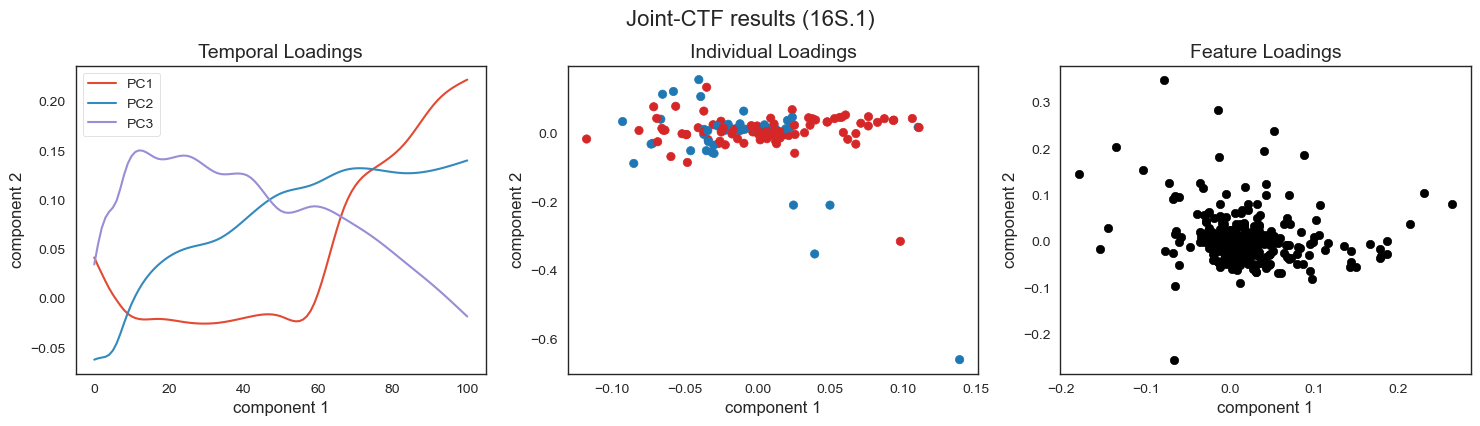

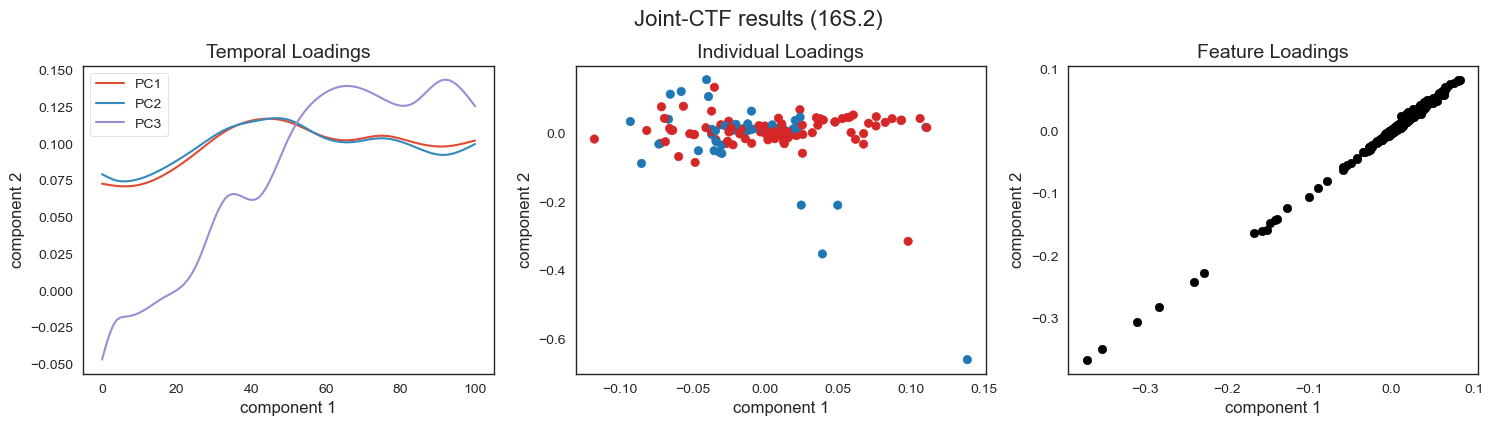

In [34]:
group_colors = {'CS': 'tab:blue', 'Vag': 'tab:red'}

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.1', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.2', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

In [35]:
print(eigenvalues)
print(prop_explained.T)
display(feature_loadings['16S.2'])

        component_1  component_2  component_3
16S.1   1149.442620   785.819145   385.584526
16S.2  10944.598869  3940.784259  1811.569447
               component_1  component_2  component_3
var_explained     0.757134     0.141326     0.101541


,component_1,component_2,component_3
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,0.004758,0.002952,0.005294
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTCTGTTAAGTCAGATGTGAAAGGTTAGGGCTCAACCCTGAACGTG,0.004640,0.005406,-0.007161
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTTTATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,0.000658,0.000618,0.001039
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTG,0.002425,-0.000859,-0.016601
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAATCCATGGGCTCAACCCGTGAATTG,-0.003357,-0.002625,-0.008842
...,...,...,...
TACGTATGTTCCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTATTTAAGTCTGAAGTGAAAGCCCTCAGCTCAACTGAGGAATGG,-0.001857,-0.001343,0.000878
TACGTATGTTCCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTATTTAAGTCTGAAGTGAAAGCCCTCAGCTCAACTGAGGAATTG,0.001932,0.001939,0.039013
TACGTATGTTGCAAGCGTTATCCGGAATTATTGGGCTTAAAGGGCATCTAGGCGGTAAGACAAGTTGAAGGTGAAAACCTGTGGCTCAACCATAGGCTTG,0.000117,0.000112,0.002385
TACGTATGTTGCGAGCGTTATCCGGAATTATTGGGCTTAAAGGGCATCTAGGCGGTAAGACAAGTTGAAGGTGAAAACCTGTGGCTCAACCATAGGCTTG,0.013804,0.008522,-0.004517


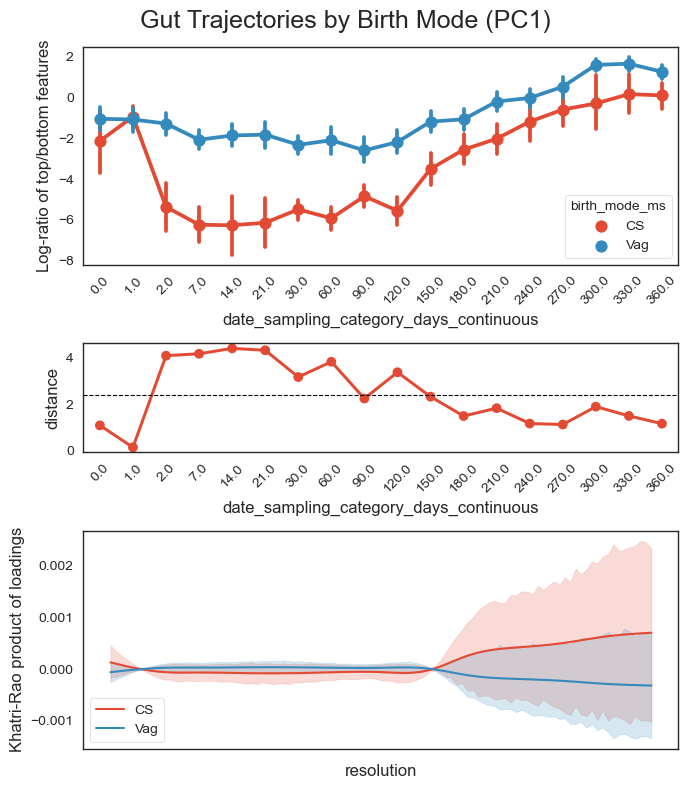

In [36]:
#calculate trajectories based on log-ratio abundance
component='component_1'
beta_l, _, _ = sub_feat_trajectory(baby_gut_table, feature_loadings, component=component,
                                   modality='16S.1', pseudocount=0.5, quantile=0.95)
#map columns of interest from mf
beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
beta_l.dropna(inplace=True)

#find timepoints at which trajectories seem to converge
cat1, cat2 = beta_l[cat_of_interest].unique()
beta_l_dist = beta_l.groupby([state_column, 
                                cat_of_interest]).mean()
beta_l_dist = beta_l_dist.unstack()
beta_l_dist.columns = beta_l_dist.columns.droplevel()
beta_l_dist.reset_index(inplace=True)
beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

#calculate trajectories based on khatri-rao product
strajectory_gut, ftrajectory_gut = temporal_trajectory(individual_loadings, feature_loadings,
                                                       state_loadings, modality='16S.1',
                                                       state_column='resolution',
                                                       component=component,
                                                       f_subset=True, quantile=0.95)

#map columns of interest from mf
strajectory_gut[cat_of_interest] = strajectory_gut['subjectID'].map(mf_all[cat_of_interest])

##plotting
fig, axn = plt.subplots(3, 1, figsize=(7, 8), gridspec_kw = {'height_ratios':[6,3,6]})
#plot trajectory #1
sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                data=beta_l, ax=axn[0], ci=68)
#axn[0].set_title('{}: {}'.format(test_title, exp_))
xlabels = axn[0].get_xticklabels()
axn[0].set_xticklabels(xlabels, rotation=45)
axn[0].set_ylabel('Log-ratio of top/bottom features')
#plot distance between points in trajectory #1
sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
              ax=axn[1], errorbar=None, scale=0.8)
axn[1].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
axn[1].set_xticklabels(xlabels, rotation=45)
#plot trajectory #2
sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
             data=strajectory_gut, ax=axn[2], ci=68)
#axn[2].set_title('{}: {}'.format(test_title, exp_))
axn[2].legend(loc='lower left')
axn[2].set_xticklabels([], rotation=45)
axn[2].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('Gut Trajectories by Birth Mode (PC1)', fontsize=18)
plt.tight_layout()
plt.show()

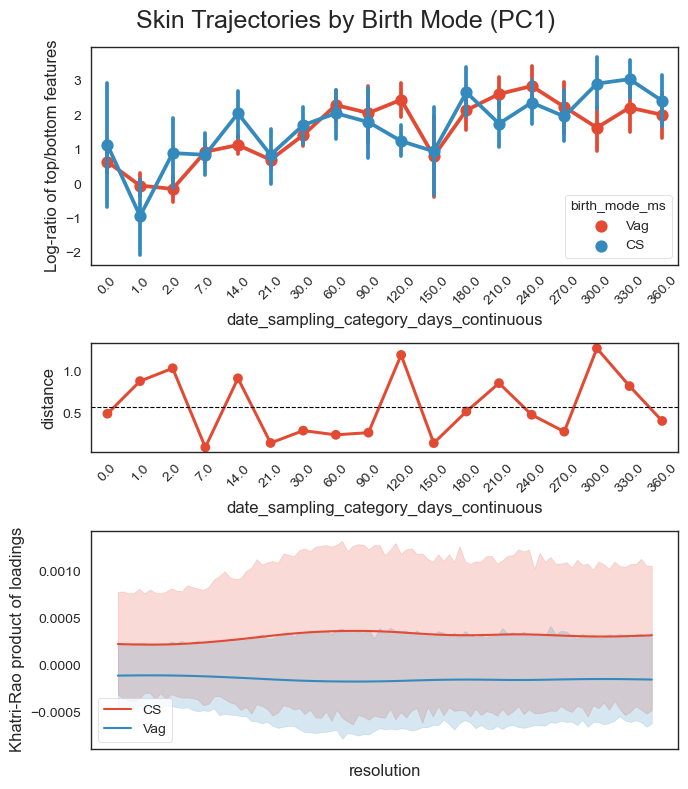

In [37]:
#calculate trajectories based on log-ratio abundance
component='component_1'
modality='16S.2'
beta_l, _, _ = sub_feat_trajectory(baby_skin_table, feature_loadings, component=component,
                                   modality=modality, pseudocount=0.5, quantile=0.95)
#map columns of interest from mf
beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
beta_l.dropna(inplace=True)

#find timepoints at which trajectories seem to converge
cat1, cat2 = beta_l[cat_of_interest].unique()
beta_l_dist = beta_l.groupby([state_column, 
                              cat_of_interest]).mean()
beta_l_dist = beta_l_dist.unstack()
beta_l_dist.columns = beta_l_dist.columns.droplevel()
beta_l_dist.reset_index(inplace=True)
beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                      beta_l_dist[cat2]) ** 2)

#calculate trajectories based on khatri-rao product
strajectory_skin, ftrajectory_skin = temporal_trajectory(individual_loadings, feature_loadings,
                                                         state_loadings, modality=modality,
                                                         state_column='resolution',
                                                         component=component,
                                                         f_subset=True, quantile=0.95)

#map columns of interest from mf
strajectory_skin[cat_of_interest] = strajectory_skin['subjectID'].map(mf_all[cat_of_interest])

##plotting
fig, axn = plt.subplots(3, 1, figsize=(7, 8), gridspec_kw = {'height_ratios':[6,3,6]})
#plot trajectory #1
sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
              data=beta_l, ax=axn[0], ci=68)
xlabels = axn[0].get_xticklabels()
axn[0].set_xticklabels(xlabels, rotation=45)
axn[0].set_ylabel('Log-ratio of top/bottom features')
#plot distance between points in trajectory #1
sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
              ax=axn[1], errorbar=None, scale=0.8)
axn[1].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
axn[1].set_xticklabels(xlabels, rotation=45)
#plot trajectory #2
sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
             data=strajectory_skin, ax=axn[2], ci=68)
axn[2].legend(loc='lower left')
axn[2].set_xticklabels([], rotation=45)
axn[2].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('Skin Trajectories by Birth Mode (PC1)', fontsize=18)
plt.tight_layout()
plt.show()

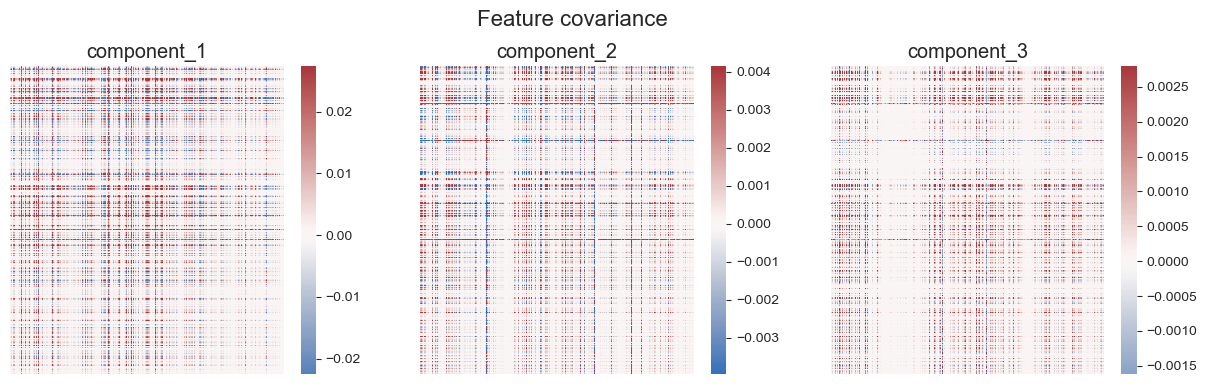

In [38]:
#plot covariance of a subset of features
plot_feature_cov(tables=[table1, table2], mod_cov=feature_covs, 
                 components=['component_1', 'component_2', 'component_3'])

In [39]:
ctf_results_skin = joint_ctf(tables=[table2],
                            sample_metadatas=[mf2],
                            modality_ids=['16S.2'],
                            individual_id_column='subjectid_unique',
                            state_column='date_sampling_category_days_continuous')

(individual_loadings, feature_loadings, state_loadings, 
 eigenvalues, prop_explained, feature_covs) = ctf_results_skin

Calculate components for component_1
Reached convergence in 5 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 13 iterations


In [40]:
comp1 = 'component_1'
comp2 = 'component_2'
cat_of_interest = 'birth_mode_ms'
state_column = 'date_sampling_category_days_continuous'
mf_all = mf2.groupby('subjectid_unique').agg({cat_of_interest:'first'})

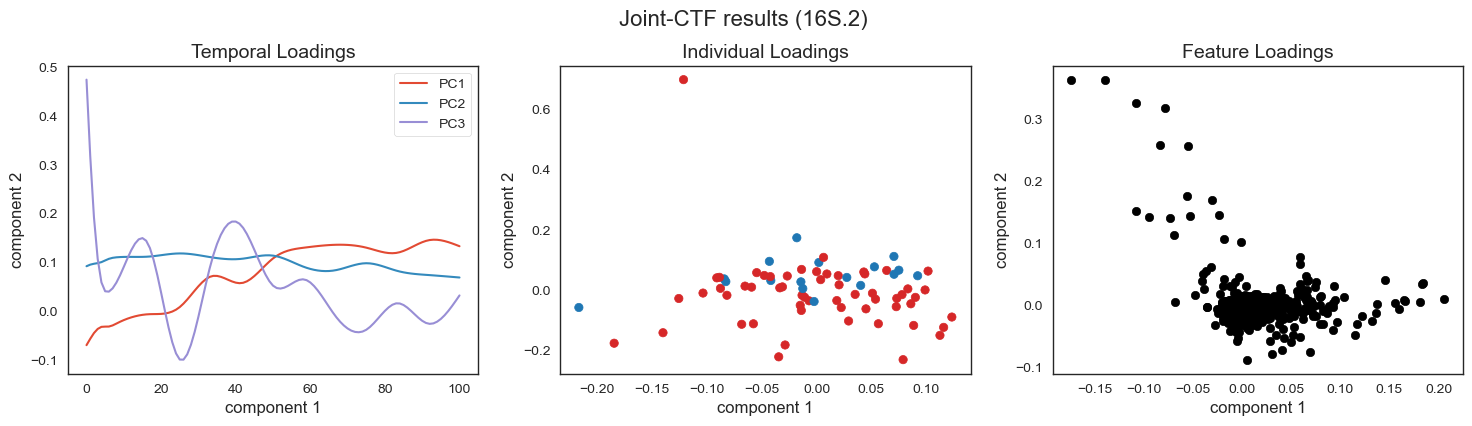

In [41]:
group_colors = {'CS': 'tab:blue', 'Vag': 'tab:red'}

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.2', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

In [42]:
print(eigenvalues)
print(prop_explained.T)
display(feature_loadings['16S.2'])

       component_1  component_2  component_3
16S.2  1001.255722   548.481905   300.800474
               component_1  component_2  component_3
var_explained     0.504748     0.311829     0.183423


,component_1,component_2,component_3
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTAAATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,0.007192,-0.002485,0.000750
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTCTGTTAAGTCAGATGTGAAAGGTTAGGGCTCAACCCTGAACGTG,-0.004696,-0.007629,0.014671
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGCAGGCGGTTTATTAAGTCAGGTGTGAAAGTTCGGGGCTCAACCCCGTGATTG,0.000647,-0.001049,0.000412
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTG,-0.012145,0.003592,0.135156
AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAATCCATGGGCTCAACCCGTGAATTG,-0.007865,0.000708,0.038501
...,...,...,...
TACGTATGTTCCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTATTTAAGTCTGAAGTGAAAGCCCTCAGCTCAACTGAGGAATGG,0.000778,0.001233,-0.001661
TACGTATGTTCCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTATTTAAGTCTGAAGTGAAAGCCCTCAGCTCAACTGAGGAATTG,0.038345,0.019699,-0.005080
TACGTATGTTGCAAGCGTTATCCGGAATTATTGGGCTTAAAGGGCATCTAGGCGGTAAGACAAGTTGAAGGTGAAAACCTGTGGCTCAACCATAGGCTTG,0.001427,-0.000310,-0.007427
TACGTATGTTGCGAGCGTTATCCGGAATTATTGGGCTTAAAGGGCATCTAGGCGGTAAGACAAGTTGAAGGTGAAAACCTGTGGCTCAACCATAGGCTTG,-0.001297,-0.022134,0.015535


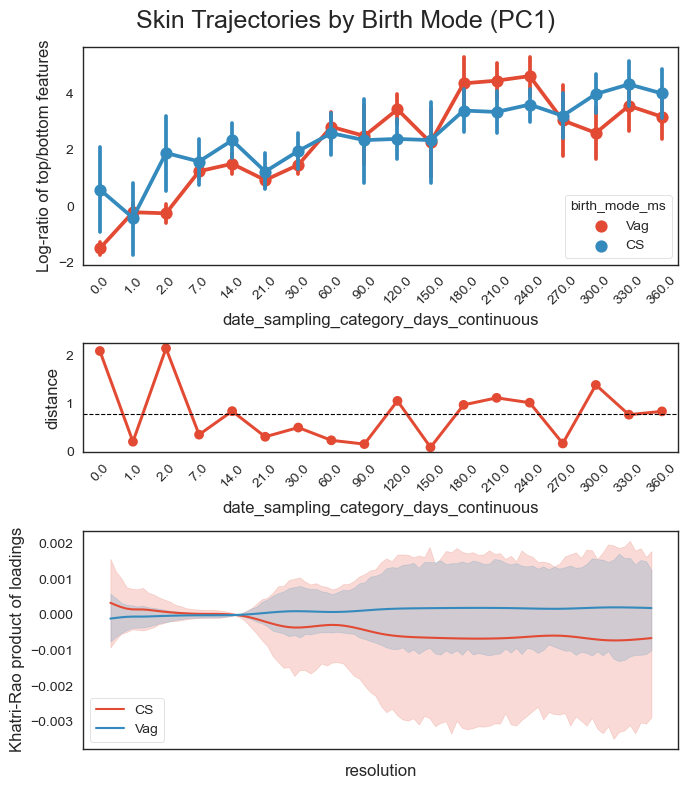

In [43]:
#calculate trajectories based on log-ratio abundance
component='component_1'
modality='16S.2'
beta_l, _, _ = sub_feat_trajectory(baby_skin_table, feature_loadings, component=component,
                                   modality=modality, pseudocount=0.5, quantile=0.95)
#map columns of interest from mf
beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
beta_l.dropna(inplace=True)

#find timepoints at which trajectories seem to converge
cat1, cat2 = beta_l[cat_of_interest].unique()
beta_l_dist = beta_l.groupby([state_column, 
                              cat_of_interest]).mean()
beta_l_dist = beta_l_dist.unstack()
beta_l_dist.columns = beta_l_dist.columns.droplevel()
beta_l_dist.reset_index(inplace=True)
beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                      beta_l_dist[cat2]) ** 2)

#calculate trajectories based on khatri-rao product
strajectory_skin, ftrajectory_skin = temporal_trajectory(individual_loadings, feature_loadings,
                                                         state_loadings, modality=modality,
                                                         state_column='resolution',
                                                         component=component,
                                                         f_subset=True, quantile=0.95)

#map columns of interest from mf
strajectory_skin[cat_of_interest] = strajectory_skin['subjectID'].map(mf_all[cat_of_interest])

##plotting
fig, axn = plt.subplots(3, 1, figsize=(7, 8), gridspec_kw = {'height_ratios':[6,3,6]})
#plot trajectory #1
sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
              data=beta_l, ax=axn[0], ci=68)
xlabels = axn[0].get_xticklabels()
axn[0].set_xticklabels(xlabels, rotation=45)
axn[0].set_ylabel('Log-ratio of top/bottom features')
#plot distance between points in trajectory #1
sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
              ax=axn[1], errorbar=None, scale=0.8)
axn[1].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
axn[1].set_xticklabels(xlabels, rotation=45)
#plot trajectory #2
sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
             data=strajectory_skin, ax=axn[2], ci=68)
axn[2].legend(loc='lower left')
axn[2].set_xticklabels([], rotation=45)
axn[2].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('Skin Trajectories by Birth Mode (PC1)', fontsize=18)
plt.tight_layout()
plt.show()

In [44]:
stop

NameError: name 'stop' is not defined

### Data-driven simulations

Placeholder code below

In [ ]:
# inits
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
experiment = 'seq-depth'
# import simulations from file
file_lst = glob.glob('../results/{}-tables/*.biom'.format(experiment))

simulations_depth = {(tbl_.split('/')[-1].split('-')[0],
                      int(tbl_.split('/')[-1].split('-')[2]),
                      int(tbl_.split('/')[-1].split('-')[3].split('.')[0])):load_table(tbl_)
                      for tbl_ in file_lst if len(tbl_.split('/')[-1].split('-')) == 4}
simulations_depth.keys()

In [ ]:
simulation_results = {}
fold = 0
depth = 5000
mf_dict = {'gut':baby_gut_mf, 'skin':baby_skin_mf, 'mouth':baby_mouth_mf}

for k_sim in tqdm([('gut','skin'), ('gut','mouth'), ('mouth','skin')]):
    print(k_sim)
    # prepare tables
    site1 = k_sim[0]
    site2 = k_sim[1]
    table1 = simulations_depth[(site1, depth, fold)].copy()
    table1 = clr_transformation(table1, pseudocount=0.5)
    table2 = simulations_depth[(site2, depth, fold)].copy()
    table2 = clr_transformation(table2, pseudocount=0.5)
    # prepare metadata
    mf1 = mf_dict[site1].copy()
    mf2 = mf_dict[site2].copy()
    # run joint-ctf
    sites = '{}-{}'.format(site1, site2)
    simulation_results[(sites, depth, fold)] = joint_ctf(tables=[table1, table2],
                                                         sample_metadatas=[mf1, mf2],
                                                         modality_ids=['16S.1','16S.2'],
                                                         individual_id_column='subjectid_unique',
                                                         state_column='date_sampling_category_days_continuous')

In [ ]:
##sim_results = subject_loads, feature_loads, state_loads, subject_lambdas, var_explained, feature_covs
cat_of_interest = 'birth_mode_ms'
permanova_results = {}

for k_sim, (ind_loads, _, _, _, _, _) in tqdm(simulation_results.items()):
    
    ind_loads = ind_loads['16S.1']
    mf_tmp = mf.copy()
    mf_tmp.index = mf_tmp.subjectid_unique
    mf_tmp = mf_tmp.loc[ind_loads.index, :]
    
    for t_, t_mf in mf_tmp.groupby(state_column):
        # calculate distance for subjects
        dists = distance.cdist(ind_loads.values, ind_loads.values)
        dists = DistanceMatrix(dists, ids=ind_loads.index)
        dists.ids = list(map(str, dists.ids))
        dist_tmp_t = dists.copy().filter(t_mf.index)
        # MAKE SURE IT IS ORDERED CORRECTLY!
        t_mf = t_mf.reindex(dist_tmp_t.ids)
        permanova_results[(k_sim[0], k_sim[1], t_)] = permanova(dist_tmp_t, 
                                                                t_mf[cat_of_interest])
        # permanova_results[(k_sim[0], k_sim[1], 
        #                    k_sim[2], t_)] = permanova(dist_tmp_t, t_mf[cat_of_interest])

permanova_results_df = pd.DataFrame(permanova_results).T.reset_index()
permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                    'level_1':'simulation_fold',
                                                    'level_2':state_column}, axis=1)
# permanova_results_df = permanova_results_df.rename({'level_0':'depth',
#                                                     'level_1':'dispersion',
#                                                     'level_2':'simulation_fold',
#                                                     'level_3':state_column}, axis=1)
permanova_results_df['depth'] = permanova_results_df['depth'].astype(int)
#permanova_results_df['dispersion'] = permanova_results_df['dispersion'].astype(int)
permanova_results_df.head(3)

In [ ]:
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
test = 'depth'
sns.barplot(x=test, y='test statistic', data=permanova_results_df, 
            ci=68, ax=axn[0])
axn[0].set_facecolor('white')
axn[0].set_xlabel(test)
sns.pointplot(x=state_column, hue=test, y='test statistic', 
              data=permanova_results_df, ci=68, ax=axn[1])
axn[1].set_facecolor('white')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.set_style('white')
mods = ['16S.1', '16S.2']
#depth = 1000
for fold_ in [1]:

    print('Fold {}'.format(fold_))
    cols = sorted(set([int(k[0]) for k in simulation_results.keys()]))
    rows = mods
    fig, axn = plt.subplots(len(rows)+1, len(cols), figsize=(10, 10))
    mf_subject_collapsed = mf.groupby(subject_id_column).agg({cat_of_interest:'first'})
    group_colors = {'Vag': 'tab:red', 'CSseed': 'tab:blue', 'CS': 'tab:green'}
    comp1 = 'component_1'
    comp2 = 'component_2'

    for i, exp in enumerate(cols):
        ind_loads, _, state_loads, _, _, _ = simulation_results[(exp, fold_)]
        #ind_loads, _, state_loads, _, _, _ = simulation_results[(depth, exp, fold_)]
        sns.scatterplot(x=ind_loads['16S.1'][comp1], 
                        y=ind_loads['16S.1'][comp2],  
                        hue=mf_subject_collapsed[cat_of_interest], 
                        palette=group_colors, ax=axn[0,i])
        axn[0,i].set_title(exp)

        sns.lineplot(data=state_loads['16S.1'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[1,i], dashes=False)
        axn[1,i].set_title('Mod1, depth = {}'.format(exp))
        axn[1,i].legend() 
        axn[1,i].set_xlabel('resolution')         
        axn[1,i].set_ylabel('loadings') 
        sns.lineplot(data=state_loads['16S.2'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[2,i], dashes=False)
        axn[2,i].set_title('Mod2, depth = {}'.format(exp))
        axn[2,i].legend() 
        axn[2,i].set_xlabel('resolution')         
        axn[2,i].set_ylabel('loadings') 

    plt.tight_layout()
    plt.show()